# Contents

In this notebook, I present the amplification of rotation errors introduced in Refs [1] and [2]. We extend this method to the qutrit case.

In [3]:
import os
os.chdir('/Users/ngdnhtien/Codespace/PulsatingPulseShop/')

# Necessary dependencies
import qiskit
import qiskit_ibm_provider
import utility as ut
import qutip as qt 
import numpy as np
import pickle 
import matplotlib.pyplot as plt
import json
import datetime

In [4]:
plt.rcParams['axes.linewidth'] = 1.0
%config InlineBackend.figure_formats = ['svg']
today = datetime.datetime.now()

In [5]:
provider = qiskit_ibm_provider.IBMProvider()
backend = provider.get_backend('ibm_brisbane')

qubit = 109
cbit = 0

num_qubits = int(qubit+1)
num_cbits = 1

weight = 1

rough_01_freq = backend.defaults().qubit_freq_est[qubit]
qubit_anharmonicty = backend.properties().qubits[qubit][3].value * 1e9
rough_12_freq = rough_01_freq + qubit_anharmonicty

print(r"f01 = "+f'{round(rough_01_freq/1e9, 4)}'+' GHz')
print(r'f12 = '+f'{round(rough_12_freq/1e9, 4)}'+' GHz')

f01 = 4.985 GHz
f12 = 4.6779 GHz


# Main script

In [6]:
amp_x12_144 = 0.13533884388565898
amp_sx12_144 = amp_x12_144/2

amp_x12_40 = 0.479702232549861
amp_sx12_40 = amp_x12_40/2

amp_x12_160 = 0.12215478026354036
amp_sx12_160 = amp_x12_160/2

In [7]:
dur_12 = 40
amp_x12 = amp_x12_40
amp_sx12 = amp_sx12_40

In [8]:
hp12 = qiskit.circuit.Gate('half_pi12', weight, [])
p12 = qiskit.circuit.Gate('pi12', weight, [])

with qiskit.pulse.build(backend=backend) as p12_sched:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    qiskit.pulse.set_frequency(rough_12_freq, drive_chan)
    qiskit.pulse.play(qiskit.pulse.Drag(duration=dur_12, amp=amp_x12, sigma=int(dur_12/4), beta=0), drive_chan)

with qiskit.pulse.build(backend=backend) as hp12_sched:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    qiskit.pulse.set_frequency(rough_12_freq, drive_chan)
    qiskit.pulse.play(qiskit.pulse.Drag(duration=dur_12, amp=amp_sx12, sigma=int(dur_12/4), beta=0), drive_chan)

In [9]:
gc = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
gc.measure(qubit, cbit)

fc = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
fc.x(qubit)
fc.measure(qubit, cbit)

sc = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
sc.x(qubit)
sc.append(p12, [qubit])
sc.x(qubit)
sc.measure(qubit, cbit)
sc.append(p12, [qubit])
sc.x(qubit)
sc.add_calibration(p12, [qubit], p12_sched)

discrim_circs = [gc, fc, sc]

In [10]:
qc_re_list = [gc, fc, sc]
N_list = np.array([2*n for n in range(21)])

for N in N_list:
    qc_re = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
    qc_re.x(qubit) # prepare |1>
    qc_re.append(hp12, [qubit]) # prepare |+>
    for i in range(N):
        qc_re.append(hp12, [qubit])
        qc_re.append(hp12, [qubit])
    qc_re.x(qubit)
    qc_re.measure(qubit, cbit)
    qc_re.append(p12, [qubit])
    qc_re.x(qubit)
    qc_re.add_calibration(hp12, [qubit], hp12_sched)
    qc_re.add_calibration(p12, [qubit], p12_sched)
    qc_re_list.append(qc_re)

re_shots = int(2**11)

In [11]:
re_job = backend.run(qc_re_list, meas_level=1, meas_return='single', shots=re_shots)
re_job.job_id()

'ctsh134ezn20008s8a7g'

In [13]:
re_job = provider.backend.retrieve_job('ctsh134ezn20008s8a7g')
re_job.status()

<JobStatus.DONE: 'job has successfully run'>

In [15]:
iqdata_retrieved = False
job_id = 'ctsh134ezn20008s8a7g'

if iqdata_retrieved == False:
    re_job = provider.backend.retrieve_job(job_id)
    re_exp = ut.DataAnalysis(experiment=re_job, average=False, shots=re_shots, qubit=0)
    re_exp.retrieve_data(average=False)
    with open('./calibrator/rotation_error/qubit109/data/fast_reset/dur40.pkl', 'wb') as f:
        pickle.dump(re_exp.IQ_data, f)

else:
    re_shots = int(2**11)
    re_exp = ut.DataAnalysis(experiment=None, average=False, shots=re_shots, qubit=0)
    re_exp.IQ_data = np.load("./calibrator/rotation_error/qubit109/data/round10_11jul24.pkl", allow_pickle=True)
    re_exp.IQ_discrim = [re_exp.IQ_data[0], re_exp.IQ_data[1], re_exp.IQ_data[2]]

re_exp.build_discrim(num_states=3)
re_exp.count_pop()
re_exp.error_mitiq()

TypeError: 'NoneType' object is not subscriptable

In [17]:
re_exp.score_012

0

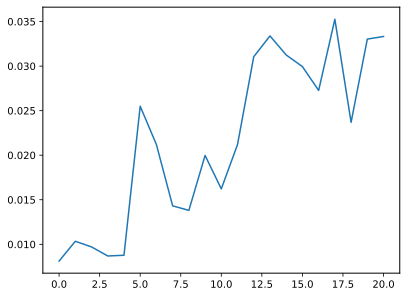

In [58]:
plt.plot(re_exp.mitiq_data[:, 1])

# Ok! Now we simulate this sequence

Now what I want is a simulation (simple, straightforward) that highlights the deviation of $p_2$ and $p_1$ from a purely rotation error model. No need for any open master equation, since we're only working with around $20$ gates (damn!). 

1. $T_1$ should not affect the populations.
2. $T_2$ would contribute to the phase error. 


#### Simulation

In [44]:
def Lx01():
    return qt.Qobj(np.array([
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 0]
    ]))

def Lz01():
    return qt.Qobj(np.array([
        [1, 0, 0],
        [0, -1, 0],
        [0, 0, 0]
    ]))

def Lx12():
    return qt.Qobj(np.array([
        [0, 0, 0],
        [0, 0, 1],
        [0, 1, 0]
    ]))

def Lz12():
    return qt.Qobj(np.array([
        [0, 0, 0],
        [0, 1, 0],
        [0, 0, -1]
    ]))

def rot_x12(a, p):
    return (-1j*((np.pi/2+a)/2)*Lx12()-1j*p*Lz12()).expm()

ket0 = qt.basis(3, 0)
ket1 = qt.basis(3, 1)
ket2 = qt.basis(3, 2)

def coherent_error_sim(rotation_angles, optimized_a, optimized_p):

    population = []

    if optimized_p == 0:
        p = 0
        for a in rotation_angles:
            for N in N_list:
                psi0 = ket1 
                psi0 = rot_x12(a, p) * psi0
                for _ in range(N):
                    psi0 = rot_x12(a, p)*rot_x12(a, p)*psi0 

                pop1 = ((ket1.dag()*psi0).norm())**2
                pop2 = ((ket2.dag()*psi0).norm())**2

                population.append([pop1, pop2])
    else: 
        for N in N_list:
            psi0 = ket1
            psi0 = rot_x12(optimized_a, optimized_p)*psi0
            for _ in range(N):
                psi0 = rot_x12(optimized_a, optimized_p)*rot_x12(optimized_a, optimized_p)*psi0

            pop1 = ((ket1.dag()*psi0).norm())**2
            pop2 = ((ket2.dag()*psi0).norm())**2
            population.append([pop1, pop2])

    population = np.array(population)

    return population

def objective(args):

    a, p = args
    
    pop2_sim = []

    for N in N_list:
        psi0 = ket1
        psi0 = rot_x12(a, p)*psi0
        for _ in range(N):
            psi0 = rot_x12(a, p)*rot_x12(a, p)*psi0

        pop2 = ((ket2.dag()*psi0).norm())**2
        pop2_sim.append(pop2)

    pop2_sim = np.array(pop2_sim)
    pop_dif = np.abs(pop2_sim - pop2_exp)**2

    return np.average(pop_dif)

In [49]:
from scipy.optimize import minimize

pop2_exp = re_exp.mitiq_data[:, 2]
N_list = np.array([2*n for n in range(21)])

x0 = [0.1, 0.01]
solution = minimize(objective, x0, method='Nelder-Mead', tol=1e-4)

In [50]:
solution

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0012487428731567244
             x: [-4.454e-02  2.728e-01]
           nit: 99
          nfev: 183
 final_simplex: (array([[-4.454e-02,  2.728e-01],
                       [-4.458e-02,  2.728e-01],
                       [-4.456e-02,  2.728e-01]]), array([ 1.249e-03,  1.249e-03,  1.249e-03]))

In [51]:
optimized_a, optimized_p = solution.x

range_a = 0.25*solution.x[0]
num_range = 50
rotation_angles = np.linspace(optimized_a-range_a, optimized_a+range_a, num_range)

pop_rotation = coherent_error_sim(rotation_angles, 0, 0)
pop_rotation = np.reshape(pop_rotation, (num_range, len(N_list), 2))

pop_rotation_and_phase = coherent_error_sim(rotation_angles, optimized_a, optimized_p)

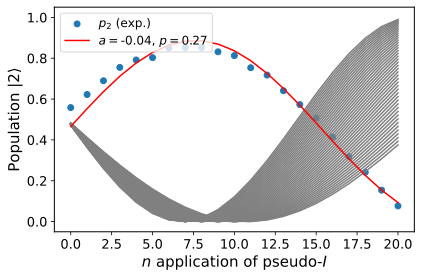

In [52]:
fig, ax = plt.subplots(figsize=(6, 4))

n_val = np.arange(0, N_list[-1]/2+1, 1)
pop2_exp = re_exp.mitiq_data[:, 2]
ax.scatter(n_val, pop2_exp, label='$p_2$ (exp.)')

for j in range(5, pop_rotation.shape[0]):
    ax.plot(n_val, pop_rotation[j][:, 1], color='gray')

ax.plot(n_val, pop_rotation_and_phase[:, 1], color='red', label=r'$a=$'+f'{np.round(optimized_a, 2)},'+r' $p=$'+f'{np.round(optimized_p, 2)}')

ax.set_ylim([-0.05, 1.05])
ax.legend(fontsize=12)
ax.set_xlabel(r'$n$ application of pseudo-$I$', fontsize=15)
ax.set_ylabel(r'Population $|2\rangle$', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=13)
fig.tight_layout()